# Предсказание   дохода



Целью данной задачи является построение модели **классификации пользователей**: на вход модель будет принимать данные о человеке, а на выходе она должна предсказывать бинарный уровень дохода человека (больше или меньше 50000$ за год).

## Загрузка библиотек

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#магическая команда, указывает, что графики нужно строить прямо в ноутбуке: 
%matplotlib inline 

In [279]:
#!pip install comet_ml

In [280]:
from comet_ml import Experiment

In [281]:
# для загрузок логин пароль
import os
from dotenv import load_dotenv

In [282]:
# загрузка данных из ".env"
load_dotenv()
# Создайте эксперимент с помощью вашего API ключа
api_key=os.getenv('api_key')
project_name=os.getenv('project_name')
workspace=os.getenv('workspace')


In [283]:
experiment = Experiment(project_name=project_name, workspace=workspace, api_key = api_key, log_code=True)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Failed to log system metrics: [sys.ram,sys.cpu,sys.load]
COMET INFO: Experiment is live on comet.com https://www.comet.com/glorit/medical-appointment/983021fa19434b7585892cc8b92e9157



## Загрузка данных

In [284]:
# %%capture
!chcp 65001
!wget https://www.dropbox.com/s/1hfrcm09qtvoeoz/train.csv?dl=1
!wget https://www.dropbox.com/s/jj7c8r0x57zda0a/test.csv?dl=1

# import wget 
# url = 'https://www.dropbox.com/s/1hfrcm09qtvoeoz/train.csv?dl=1' 
# out_dir = './' 
# wget.download(url, out_dir)

Active code page: 65001


'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [285]:
training_data = pd.read_csv('../../data/adult/train.csv')
test_data = pd.read_csv('../../data/adult/test.csv')

# training_data = pd.read_csv('https://www.dropbox.com/s/1hfrcm09qtvoeoz/train.csv?dl=1')
# test_data = pd.read_csv('https://www.dropbox.com/s/jj7c8r0x57zda0a/test.csv?dl=1')

In [286]:
training_data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
1,27,NaN,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States,0
2,44,NaN,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States,0
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States,0
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States,0


Проверим размерности наших файлов:

In [287]:
training_data.shape, test_data.shape

((24420, 13), (8141, 13))

**Работаем с целевой переменной**



In [288]:
target_name = 'income'

In [289]:
y_train = training_data[target_name]
y_test = test_data[target_name]

X_train = training_data.drop(columns=[target_name])
X_test = test_data.drop(columns=[target_name])

**Оценка сбалансированности выборки**

In [290]:
y_train.value_counts(normalize=True)

income
0    0.757821
1    0.242179
Name: proportion, dtype: float64

Таким образом, имеем задачу **несбалансированной бинарной классификации**. 

## Общая статистика по числовым данным



In [291]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


{'web': 'https://www.comet.com/api/image/download?imageId=20477d7e51144a1daa919154dcc4b99f&experimentKey=983021fa19434b7585892cc8b92e9157',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=20477d7e51144a1daa919154dcc4b99f&experimentKey=983021fa19434b7585892cc8b92e9157',
 'imageId': '20477d7e51144a1daa919154dcc4b99f'}

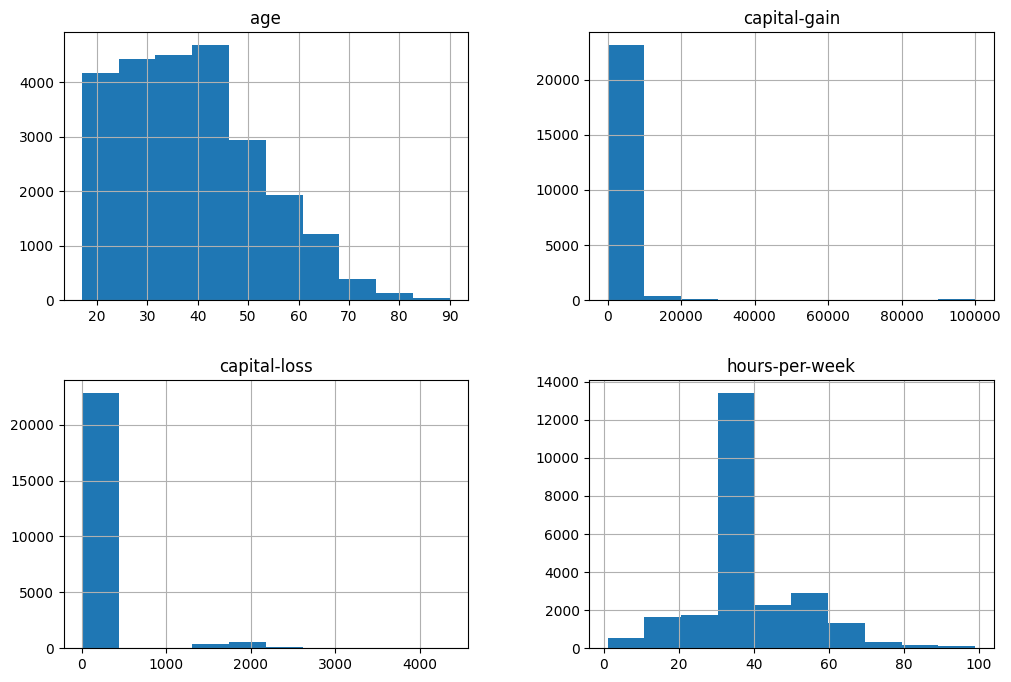

In [292]:
X_train.hist(figsize=(12,8))
experiment.log_figure('X_train_numeric_distr', plt)

Что мы можем увидеть из результатов?
* Числовых переменных в исходных данных только 4;
* Возраст пользователя варьируется в диапазоне от 17 до 90 лет и в среднем составляет 39 лет;
* Видим пропуски в признаках capital-gain и capital-loss (значение count меньше размера данных). По гистограмме можно заметить, что большое количество значений в этих признаках - это просто нули;

## Предобработка данных

### Проверка на наличие пропусков и типов переменных



In [293]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


Типы в наших данных:
* 8 признаков типа **object** - обычно это строковые значения;
* 3 признака типа **int64** - целочисленные значения;
* 2 признака типа **float64** - числа с плавающей запятой. 

Кроме этого, мы видим, что признаки *workclass, education, capital-gain и capital-loss* имеют пропуски в данных.

### Обработка пропусков в данных

Далеко не все алгоритмы умеют работать с пропусками в данных. Кроме этого, удачно заполнив пропуски, мы сможем лучше восстановить распределение данных, а значит лучше построить моделей. 

Самые популярные методы для обработки пропусков:
- Удаление значений с пропусками (не желательно при большом количестве пропусков, потому что теряются данные);
- Заполнение средним/медианным значением;
- Заполненние самым частым значением;
- Заполнение случайным значением.

**Важно:** тестовую выборку мы всегда обрабатываем также, как и обучающую выборку. 

In [294]:
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)

Сделаем то же самое для тестовой выборки:

In [295]:
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)
X_test['capital-gain'] = X_test['capital-gain'].fillna(0)

In [296]:
X_train['workclass'].value_counts(True).head(1)

workclass
Private    0.696766
Name: proportion, dtype: float64

In [297]:
X_train['education'].value_counts(True).head(1)

education
HS-grad    0.322484
Name: proportion, dtype: float64

Наиболее частое значение признака **workclass** - Private, признака **education** - HS-grad. 

Теперь явно заполним пропуски:

In [298]:
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

Сделаем то же самое для тестовой выборки:

In [299]:
X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

### Кодировка категориальных переменных

В данных 8 столбцов являются категориальными признаками. При чём в нашей задаче эти признаки **текстовые**. Машине сложно обрабатывать текстовые признаки, поэтому нам необходимо закодировать их, то есть преобразовать в числовые. 

Для начала необходимо выделить категорильные признаки:

In [300]:
categorical_features = ['workclass', 'education', 'marital-status', 
                        'occupation', 'relationship', 'race', 'sex', 
                        'native-country']

non_categorical_features = ['age', 'capital-gain', 'capital-loss', 
                            'hours-per-week']

Посмотрим на столбцы категориальных переменных:

In [301]:
X_train[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


Мы рассмотрим два популярных метода кодирования категориальных признаков:
* Label Encoding, которому соответствует класс `LabelEncoder()` из библиотеки **sklearn**
* One Hot Encoding, которому соответствует класс `OneHotEncoder()` из библиотеки **sklearn**

**Label Encoding**



In [302]:
from sklearn.preprocessing import LabelEncoder

In [303]:
label_encoder = LabelEncoder()

In [304]:
X_train_le = X_train.copy()
X_train_oe = X_train.copy()

In [305]:
X_test_le = X_test.copy()
X_test_oe = X_test.copy()

In [306]:
for feature in categorical_features:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

In [307]:
X_train_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39


**One Hot Encoding**



In [308]:
from sklearn.preprocessing import OneHotEncoder

In [309]:
onehot_encoder = OneHotEncoder()

In [310]:
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
X_train_onehot = onehot_encoder.fit_transform(X_train[categorical_features]).toarray()

# применяем полученное преобразование к тестовой выборке, результат переводим в массив
X_test_onehot = onehot_encoder.transform(X_test[categorical_features]).toarray()

# запишем полученные названия новых колонок в отдельную переменную
columns = onehot_encoder.get_feature_names_out(categorical_features)

In [311]:
X_train_onehot = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=columns)

И наконец, запишем в новую переменную полученный результат, удалив все незакодированные категориальные признаки из новой таблицы. 

In [312]:
# соединяем новую табличку с исходной
X_train_new = pd.concat([X_train, X_train_onehot], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot], axis=1)

# удаляем старые категориальные признаки
X_train_new = X_train_new.drop(columns=categorical_features)
X_test_new = X_test_new.drop(columns=categorical_features)

In [313]:
X_train_new.head()

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,49,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,27,0.0,0.0,45,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,44,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,59,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,54,0.0,1408.0,38,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Обучение модели 

## Выбор метода обучения классификатора

Для обучения классификатора воспользуемся логистической регрессией.
 

In [314]:
from sklearn.linear_model import LogisticRegression

Создаем прототип класса модели:

In [315]:
linear_model = LogisticRegression()
linear_model_oh = LogisticRegression()
linear_model_oe = LogisticRegression()

## Обучение модели на разных типах закодированных данных

In [316]:
linear_model_oh.fit(X_train_new, y_train)

c:\Users\Temnykov\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [317]:
linear_model.fit(X_train_le, y_train)

c:\Users\Temnykov\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Валидация модели на тестовой выборке

In [318]:
prediction_oh = linear_model_oh.predict(X_test_new)
prediction_le = linear_model.predict(X_test_le)

In [319]:
np.unique(prediction_oh)

array([0, 1], dtype=int64)

In [320]:
# Сколько 1го класса присутсвует в предсказаниях?
sum(prediction_oh)/len(prediction_oh)

0.1741800761577202

In [321]:
# Сколько 1го класса присутсвует в y_test?
sum(y_test)/len(y_test)

0.23670310772632355

## Точность предсказания

Посчитаем точность (**accuracy**) работы моделей. Напомним, что точность отражает, сколько в процентном соотношении от размера тестовой выборки модель угадала 1 и сколько угадала 0.

Функция для подсчета точности реализована в библиотеке **sklearn** и называется `accuracy_score()`.

In [322]:
from sklearn.metrics import accuracy_score

In [323]:
acc_oh = accuracy_score(y_test, prediction_oh)

In [324]:
acc_oh

0.8458420341481391

In [325]:
experiment.log_metric('Accuracy OneHot data', acc_oh)

Сравним значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0. Для этого можно в функцию `accuracy_score()` в качестве второго аргумента передать массив нулей такого же размера. Это делается с помощью функции `zeros_like()` из библиотеки **numpy**.

In [326]:
print('Accuracy Major Class: ', accuracy_score(y_test, np.zeros_like(y_test)).round(3))

Accuracy Major Class:  0.763


In [327]:
# Залогировать accuracy для LE
acc_le = accuracy_score(y_test, prediction_le)
experiment.log_metric('Accuracy LE data', acc_le)

## Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности. 


|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         | 


In [328]:
from sklearn.metrics import confusion_matrix

In [329]:
pd.DataFrame(confusion_matrix(y_test, prediction_oh))

,0,1
0,5841,373
1,882,1045


In [330]:
experiment.log_confusion_matrix(y_test, prediction_oh)

{'web': 'https://www.comet.com/api/asset/download?assetId=95275ea8246147fbbd946bd9e32be015&experimentKey=983021fa19434b7585892cc8b92e9157',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=95275ea8246147fbbd946bd9e32be015&experimentKey=983021fa19434b7585892cc8b92e9157',
 'assetId': '95275ea8246147fbbd946bd9e32be015'}

## Прогноз вероятности принадлежности к классу

In [331]:
pred_proba_oh = linear_model_oh.predict_proba(X_test_new)

In [332]:
# Как выглядят предсказания?
pred_proba_oh

array([[0.9637903 , 0.0362097 ],
       [0.60386604, 0.39613396],
       [0.3168389 , 0.6831611 ],
       ...,
       [0.98708327, 0.01291673],
       [0.48115216, 0.51884784],
       [0.35120333, 0.64879667]])

In [333]:
pred_proba = pred_proba_oh[:, 1]

Посмотрим на распределение предсказанной классификатором вероятности дохода > 50к, метки `1`.

{'web': 'https://www.comet.com/api/image/download?imageId=48a03f1ace4b4ef4b821011599f8d9b3&experimentKey=983021fa19434b7585892cc8b92e9157',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=48a03f1ace4b4ef4b821011599f8d9b3&experimentKey=983021fa19434b7585892cc8b92e9157',
 'imageId': '48a03f1ace4b4ef4b821011599f8d9b3'}

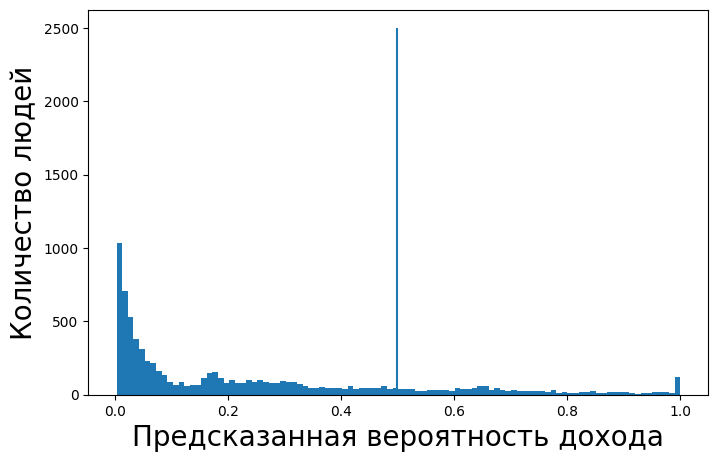

In [334]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba, bins=100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability', plt)

##ROC кривая классификатора

Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:

* Доля ложноположительных срабатываний $\text{FPR} = \frac{FP}{FP + TN}$;
* Доля истинно положительных срабатываний $\text{TPR} = \frac{TP}{TP + FN}$.

Заметим, что $FP + TN$ дает общее число объектов класса $0$, а $TP + FN$ - общее число объектов класса $1$. 

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC расшифровывается как *Receiver Operating Characteristic*. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (**TPR**) от доли ложно позитивных срабатываний (**FPR**) при изменении порога классификации.

Функция `roc_curve()` из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога `threshold`, при котором достигается соответствующие значения метрик **FPR** и **TPR**.

На вход функции `roc_curve()` необходимо передать два аргумента:
* истинные значения меток
* вероятности, предсказанные моделью

In [335]:
from sklearn.metrics import roc_curve

In [336]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba)

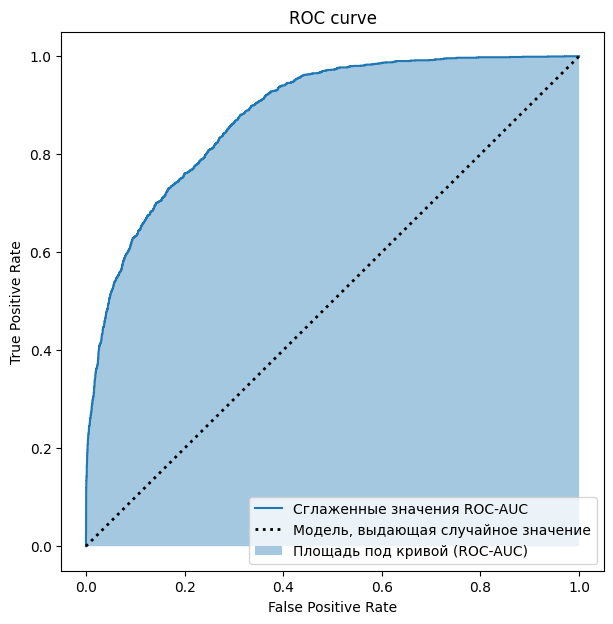

In [337]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [338]:
from sklearn.metrics import roc_auc_score

In [339]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)

In [340]:
print("ROC-AUC на тестовой выборке:", roc_auc_score(y_test, pred_proba).round(3)) 

ROC-AUC на тестовой выборке: 0.881


In [341]:
experiment.log_metric('roc_auc OneHot data', roc_auc)

In [342]:
pred_proba_le = linear_model.predict_proba(X_test_le)

In [343]:
pred_proba = pred_proba_le[:, 1]

In [344]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)
roc_auc

0.785

In [345]:
experiment.log_metric('roc_auc LE data', roc_auc)

In [346]:
X_train_oe

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States
1,27,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States
2,44,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
24415,47,Private,Bachelors,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States
24416,31,Private,12th,Divorced,Other-service,Unmarried,White,Female,0.0,0.0,21,United-States
24417,18,Private,11th,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,20,United-States
24418,50,Self-emp-not-inc,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,84,United-States


In [347]:
from sklearn.preprocessing import OrdinalEncoder

# Инициализация OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

X_train_oe[categorical_features] = ordinal_encoder.fit_transform(X_train_oe[categorical_features])
X_test_oe[categorical_features] = ordinal_encoder.transform(X_test_oe[categorical_features])



In [348]:
linear_model_oe.fit(X_train_oe, y_train)
prediction_oe = linear_model_oe.predict(X_test_oe)
acc_oe = accuracy_score(y_test, prediction_oe)
experiment.log_metric('Accuracy OrdinalEncoder data', acc_oe)

c:\Users\Temnykov\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [349]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/glorit/medical-appointment/983021fa19434b7585892cc8b92e9157
COMET INFO:   Metrics:
COMET INFO:     Accuracy LE data             : 0.804692298243459
COMET INFO:     Accuracy OneHot data         : 0.8458420341481391
COMET INFO:     Accuracy OrdinalEncoder data : 0.804692298243459
COMET INFO:     roc_auc LE data              : 0.785
COMET INFO:     roc_auc OneHot data          : 0.881
COMET INFO:   Parameters:
COMET INFO:     C                     : 1.0
COMET INFO:     categories            : auto
COMET INFO:     class_weight          : None
COMET INFO:     drop                  : None
COMET INFO:     dtype                 : <class